In [19]:
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import datetime as dt
import time

In [20]:
# portfolio of crypto
crypto = ['BTC-USD', 'ETH-USD', 'BNB-USD']

In [21]:
import yfinance as yf

# Download historical data from yf API
data = yf.download(crypto, group_by='ticker', period="max")

# download data to csv
data.to_csv("crypto.csv")

[*********************100%***********************]  3 of 3 completed


In [22]:
# Load the CSV with MultiIndex columns (Tickers, OHLCV)
df = pd.read_csv("crypto.csv", header=[0,1], index_col=0)

# df.head()

In [23]:
# # Drop any rows that are completely NaN (e.g. 'Date' row)
# df = df.dropna(how='all')

# Forward fill missing values for each column
df = df.fillna(method='ffill')

# Backfill any remaining NaN values with 0
df = df.fillna(0)

# Convert all values to float
df = df.astype(float)

# Set the index to datetime
df.index = pd.to_datetime(df.index)

# From level 0 columns, replace '-USD' with empty string to keep only ticker symbols
df.columns = df.columns.set_levels(df.columns.levels[0].str.replace('-USD', ''), level=0)

# Show the result
df.head()

Ticker      ETH                         BNB                         \
Price      Open High  Low Close Volume Open High  Low Close Volume   
Date                                                                 
2014-09-17  0.0  0.0  0.0   0.0    0.0  0.0  0.0  0.0   0.0    0.0   
2014-09-18  0.0  0.0  0.0   0.0    0.0  0.0  0.0  0.0   0.0    0.0   
2014-09-19  0.0  0.0  0.0   0.0    0.0  0.0  0.0  0.0   0.0    0.0   
2014-09-20  0.0  0.0  0.0   0.0    0.0  0.0  0.0  0.0   0.0    0.0   
2014-09-21  0.0  0.0  0.0   0.0    0.0  0.0  0.0  0.0   0.0    0.0   

Ticker             BTC                                                  
Price             Open        High         Low       Close      Volume  
Date                                                                    
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800.0  
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200.0  
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700.0  
2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600.0  
2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100.0

In [24]:
btc = df['BTC']
eth = df['ETH'] 
bnb = df['BNB']

In [25]:
# create a list with the dataframes
crypto_dfs = [btc, eth, bnb]

In [26]:
# iterate over the list and calculate returns and drawdowns for each dataframe
crypto_names = ['BTC', 'ETH', 'BNB']
crypto_dfs = [btc, eth, bnb]

for name, crypto_df in zip(crypto_names, crypto_dfs):
    # Filter out rows where Close is 0 (before the asset existed)
    valid_data = crypto_df[crypto_df['Close'] > 0].copy()
    
    # Calculate simple returns with pct_change()
    valid_data['simple_returns'] = valid_data['Close'].pct_change().fillna(0)

    # Cumulative product of simple returns (correct for compounding)
    valid_data['cumprod_simple'] = (1 + valid_data['simple_returns']).cumprod() - 1

    valid_data['cumumax'] = valid_data['cumprod_simple'].cummax()

    valid_data['drawdown'] = (valid_data['cumprod_simple'] - valid_data['cumumax']) / (valid_data['cumumax'] + 1)
    
    # Update the original dataframe
    crypto_df.loc[valid_data.index, ['simple_returns', 'cumprod_simple', 'cumumax', 'drawdown']] = valid_data[['simple_returns', 'cumprod_simple', 'cumumax', 'drawdown']]
    
    max_drawdown = valid_data['drawdown'].min()
    print(f"Max Drawdown for {name}: {max_drawdown:.2%}")
    print(f"  Data range: {valid_data.index.min()} to {valid_data.index.max()}")

Max Drawdown for BTC: -83.40%
  Data range: 2014-09-17 00:00:00 to 2025-12-22 00:00:00
Max Drawdown for ETH: -93.96%
  Data range: 2017-11-09 00:00:00 to 2025-12-22 00:00:00
Max Drawdown for BNB: -80.10%
  Data range: 2017-11-09 00:00:00 to 2025-12-22 00:00:00


In [27]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4115 entries, 2014-09-17 to 2025-12-22
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            4115 non-null   float64
 1   High            4115 non-null   float64
 2   Low             4115 non-null   float64
 3   Close           4115 non-null   float64
 4   Volume          4115 non-null   float64
 5   simple_returns  4115 non-null   float64
 6   cumprod_simple  4115 non-null   float64
 7   cumumax         4115 non-null   float64
 8   drawdown        4115 non-null   float64
dtypes: float64(9)
memory usage: 450.5 KB


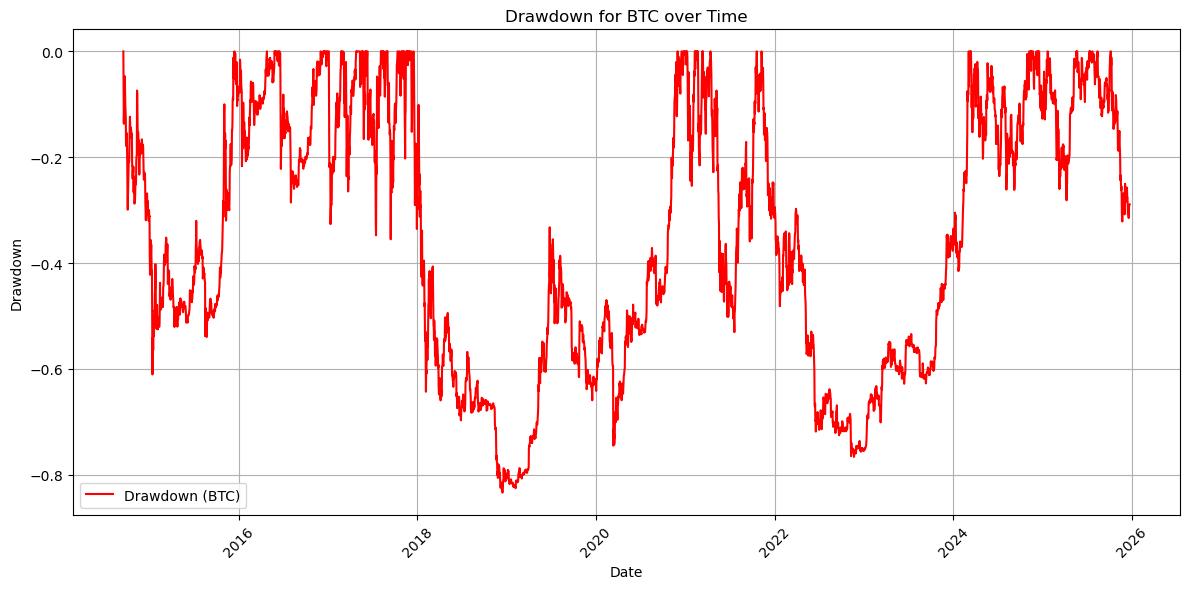

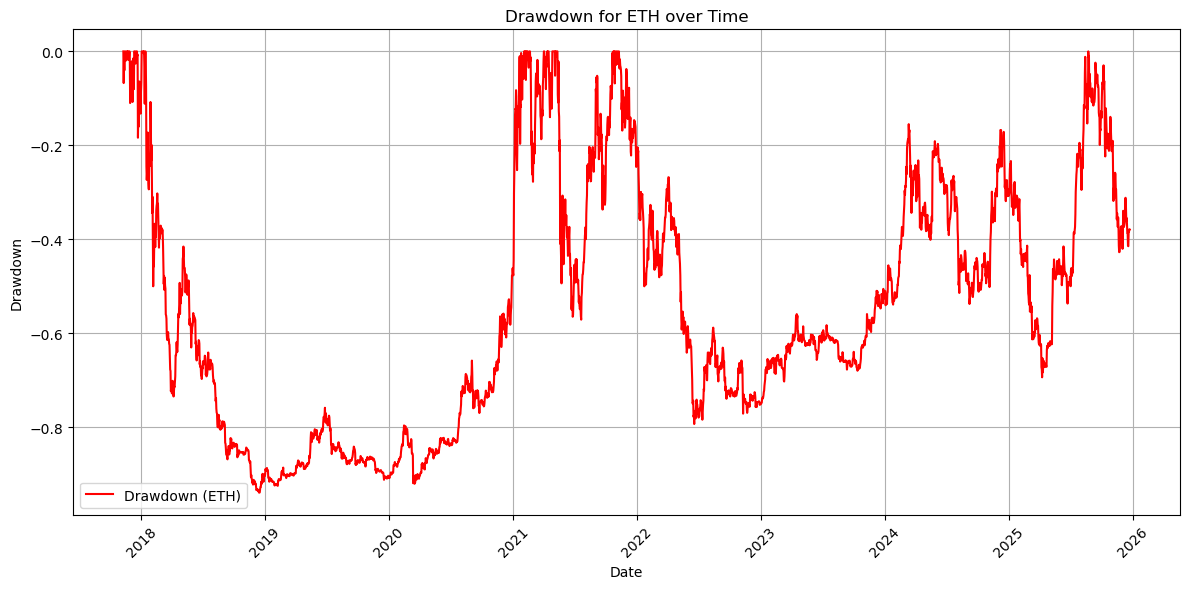

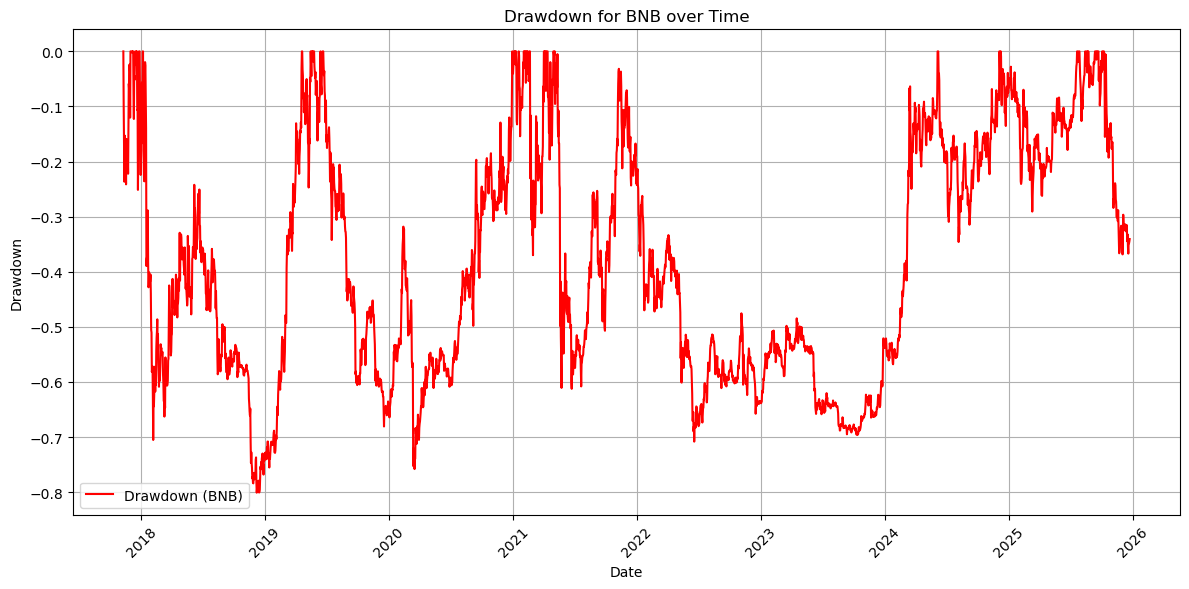

In [28]:
for name, crypto_df in zip(crypto_names, crypto_dfs):
    # plot drawdown
    plt.figure(figsize=(12, 6))
    plt.plot(crypto_df.index, crypto_df['drawdown'], label=f'Drawdown ({name})', color='red')
    plt.title(f'Drawdown for {name} over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.show()

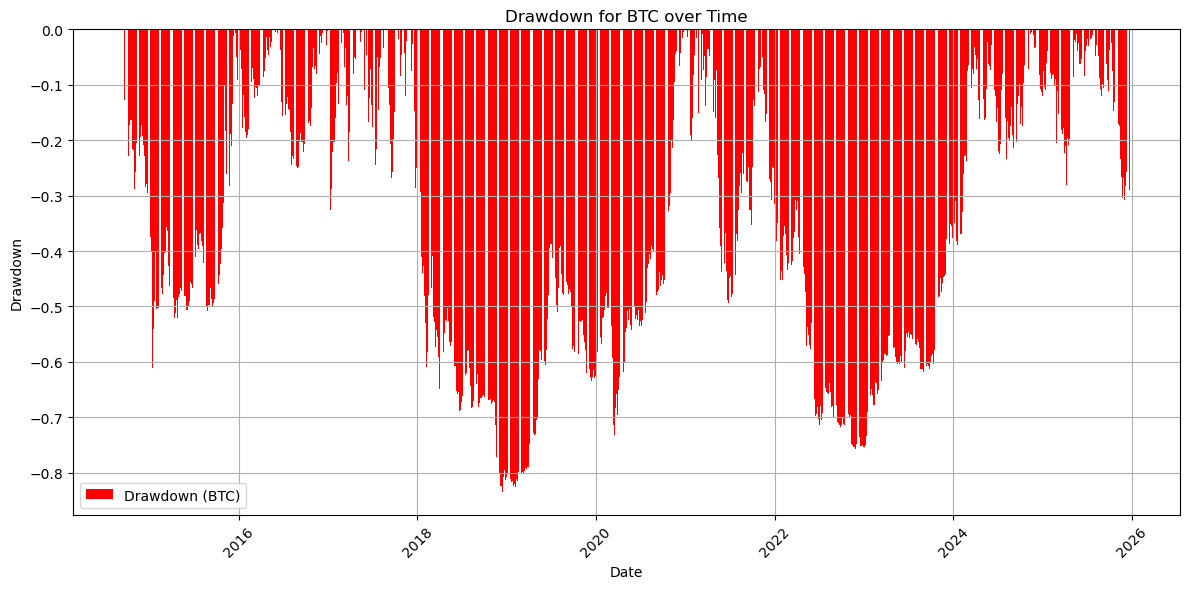

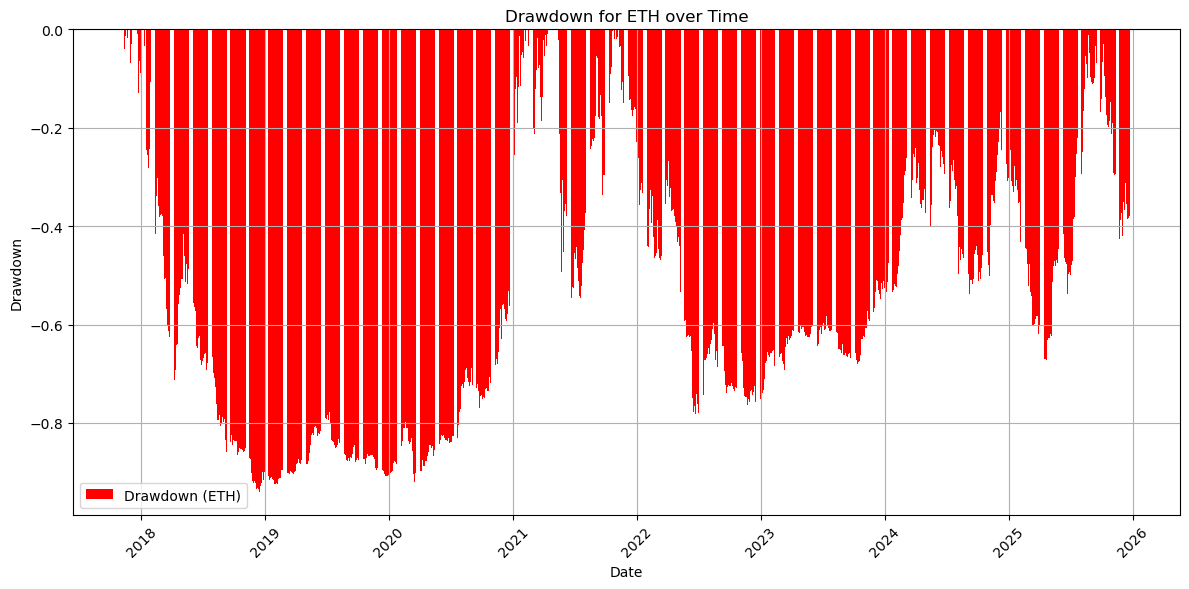

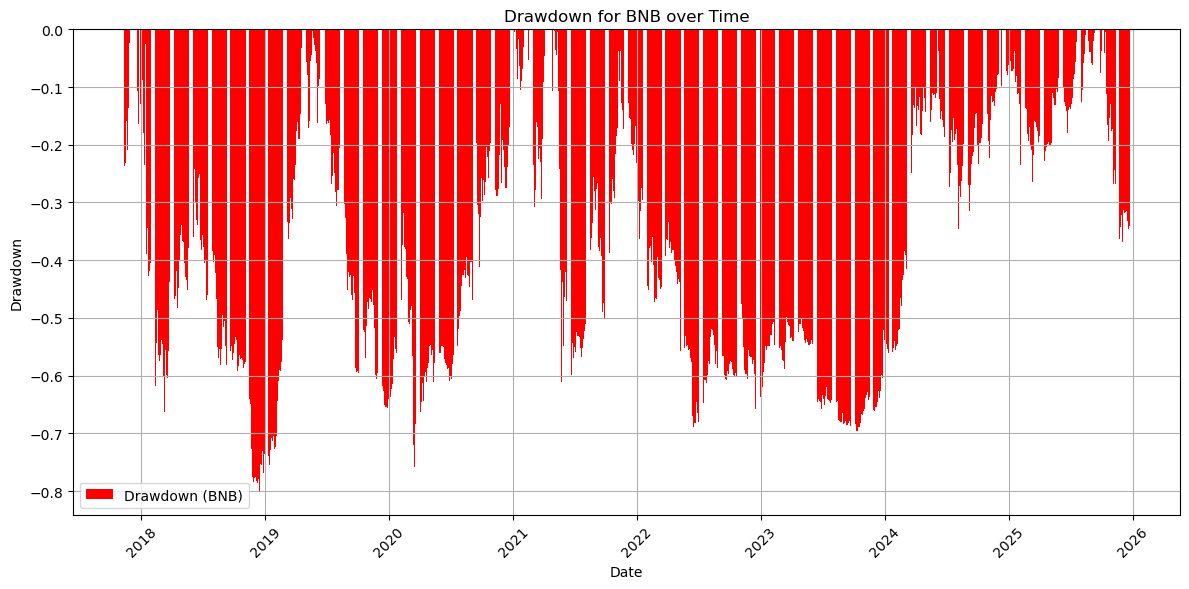

In [29]:
# drawdown plots with bars
for name, crypto_df in zip(crypto_names, crypto_dfs):
    plt.figure(figsize=(12, 6))
    plt.bar(crypto_df.index, crypto_df['drawdown'], label=f'Drawdown ({name})', color='red')
    plt.title(f'Drawdown for {name} over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.show()

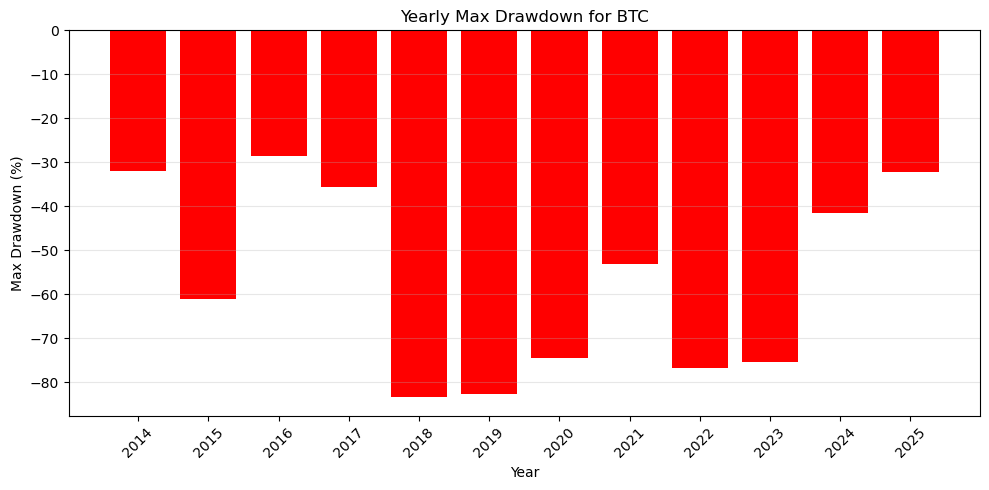

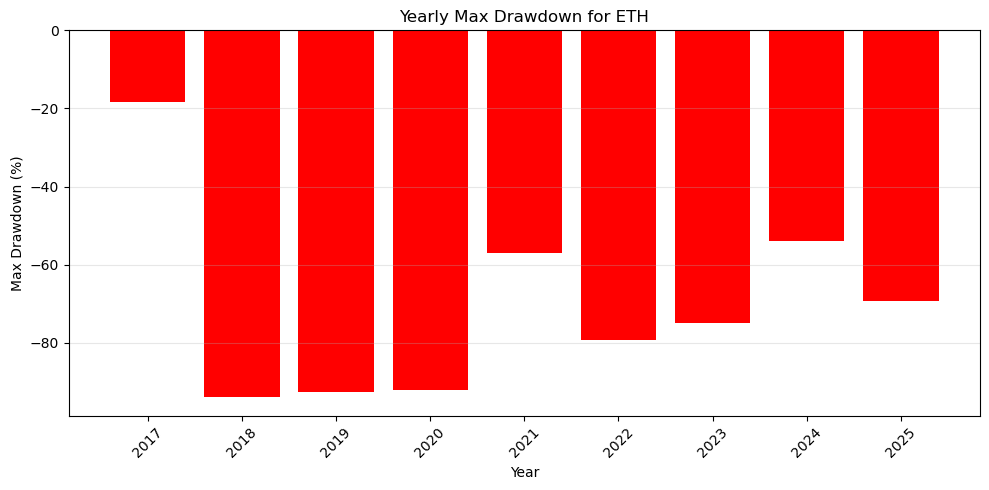

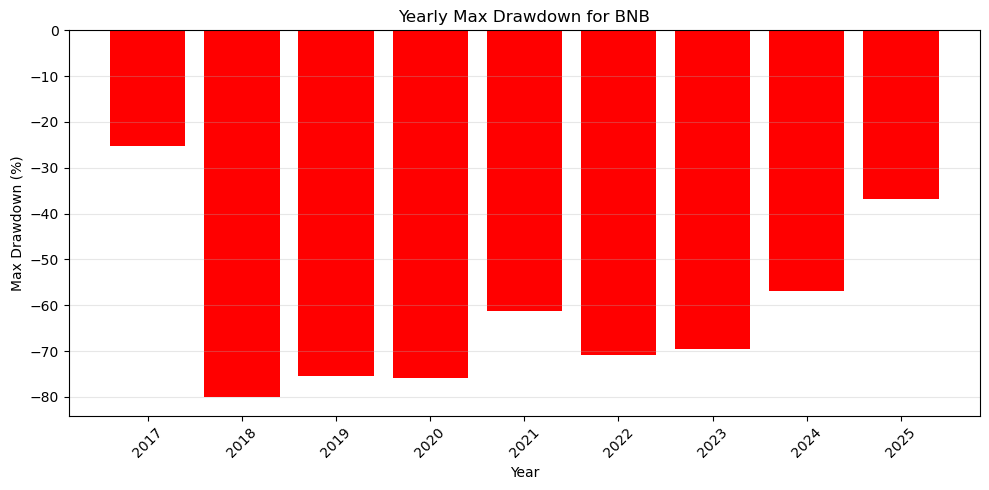

In [30]:
# intrayear drawdown analysis
for name, crypto_df in zip(crypto_names, crypto_dfs):
    # Filter valid data (Close > 0)
    valid_data = crypto_df[crypto_df['Close'] > 0]
    
    # Resample to yearly frequency and calculate max drawdown for each year
    yearly_drawdown = valid_data['drawdown'].resample('YE').min()

    # Plot yearly drawdown
    plt.figure(figsize=(10, 5))
    years = yearly_drawdown.index.year
    plt.bar(years, yearly_drawdown * 100, color='red')  # Convert to percentage
    plt.title(f'Yearly Max Drawdown for {name}')
    plt.xlabel('Year')
    plt.ylabel('Max Drawdown (%)')
    plt.xticks(years, rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

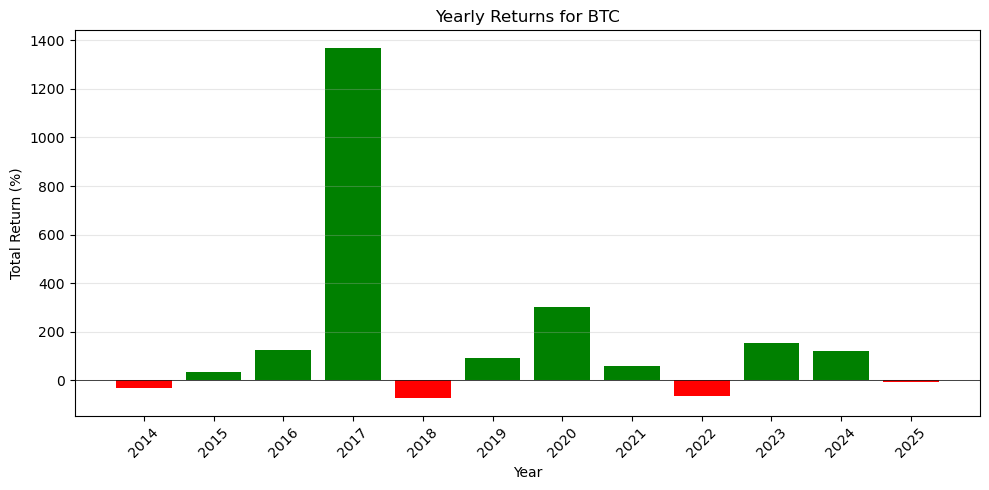

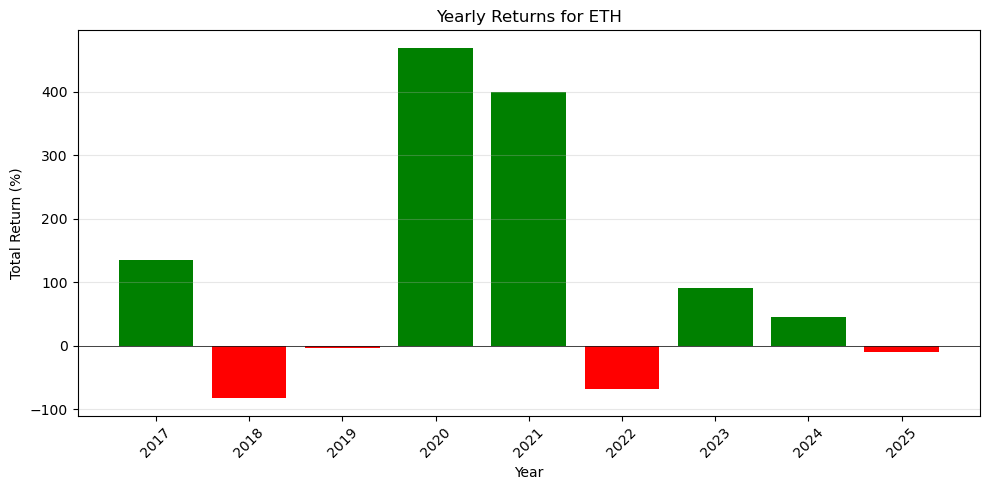

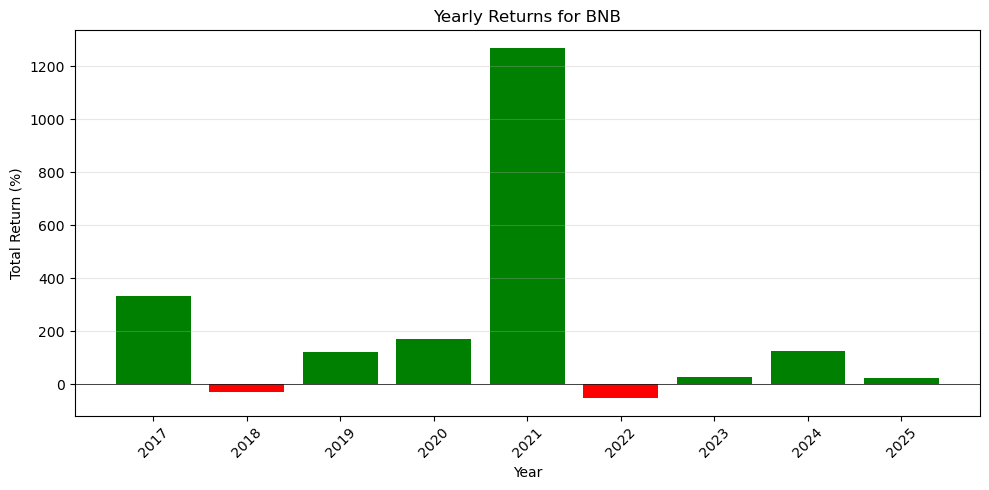

In [31]:
# intrayear returns analysis
for name, crypto_df in zip(crypto_names, crypto_dfs):
    # Filter valid data (Close > 0)
    valid_data = crypto_df[crypto_df['Close'] > 0]
    
    # Resample to yearly frequency and calculate total return for each year
    yearly_returns = valid_data['simple_returns'].resample('YE').apply(lambda x: (1 + x).prod() - 1)

    # Plot yearly returns
    plt.figure(figsize=(10, 5))
    years = yearly_returns.index.year
    colors = ['green' if r >= 0 else 'red' for r in yearly_returns]
    plt.bar(years, yearly_returns * 100, color=colors)  # Convert to percentage
    plt.title(f'Yearly Returns for {name}')
    plt.xlabel('Year')
    plt.ylabel('Total Return (%)')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.xticks(years, rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [32]:
import plotly.graph_objects as go

# iterate over the list and group by df and YEAR, then plot drawdown per year and returns per year
for name, crypto_df in zip(crypto_names, crypto_dfs):
    # Filter valid data (Close > 0)
    valid_data = crypto_df[crypto_df['Close'] > 0]
    
    # Resample to yearly frequency and calculate max drawdown and total return for each year
    yearly_drawdown = valid_data['drawdown'].resample('YE').min()
    yearly_returns = valid_data['simple_returns'].resample('YE').apply(lambda x: (1 + x).prod() - 1)

    years = yearly_drawdown.index.year.tolist()

    # Create figure
    fig = go.Figure()

    # Add drawdown bars (negative values, below zero) - darker red
    fig.add_trace(go.Bar(
        x=[y - 0.2 for y in years],
        y=yearly_drawdown.values * 100,
        width=0.4,
        name='Max Drawdown',
        marker_color='darkred',
        opacity=0.8
    ))

    # Add return bars - green for positive, red for negative
    colors = ['green' if r >= 0 else 'red' for r in yearly_returns]
    fig.add_trace(go.Bar(
        x=[y + 0.2 for y in years],
        y=yearly_returns.values * 100,
        width=0.4,
        name='Total Return',
        marker_color=colors,
        opacity=0.8
    ))

    # Add horizontal line at zero
    fig.add_hline(y=0, line_color='black', line_width=1)

    # Update layout
    fig.update_layout(
        title=f'Yearly Max Drawdown and Returns for {name}',
        xaxis_title='Year',
        yaxis_title='Percentage (%)',
        xaxis=dict(
            tickmode='array',
            tickvals=years,
            tickangle=45
        ),
        legend=dict(
            yanchor='top',
            y=0.99,
            xanchor='left',
            x=0.01
        ),
        barmode='group',
        template='plotly_white',
        height=500,
        width=900
    )

    fig.show()

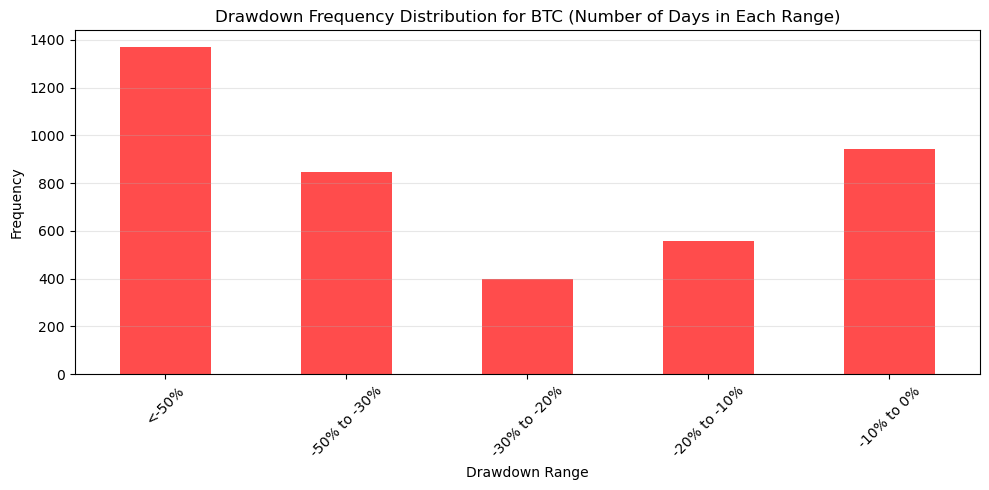

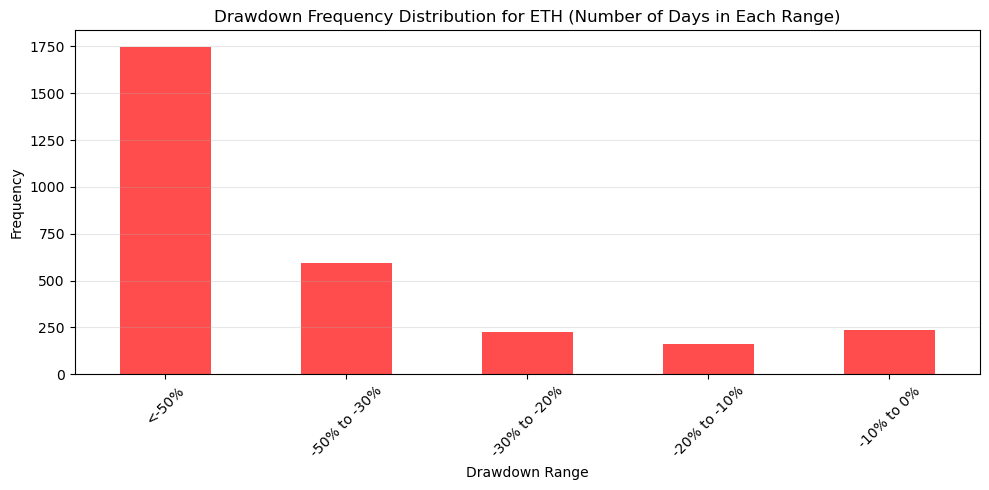

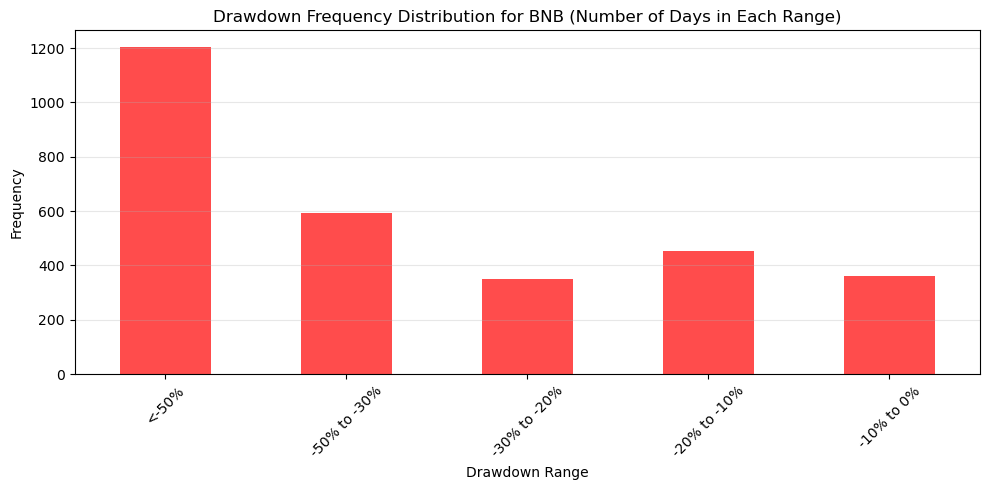

In [33]:
"""
The frequency in each bin represents the number of days where the drawdown fell within each specified range.

Here's what each bin means:

Bin	Meaning
<-50%	Days when the portfolio was down more than 50% from its peak
-50% to -30%	Days when down between 30% and 50% from peak
-30% to -20%	Days when down between 20% and 30% from peak
-20% to -10%	Days when down between 10% and 20% from peak
-10% to 0%	Days when down less than 10% from peak (or at peak)
"""

# drawdown frequency analysis
for name, crypto_df in zip(crypto_names, crypto_dfs):
    # Filter valid data (Close > 0)
    valid_data = crypto_df[crypto_df['Close'] > 0]
    
    # Define drawdown bins
    bins = [-1.0, -0.5, -0.3, -0.2, -0.1, 0.0]
    labels = ['<-50%', '-50% to -30%', '-30% to -20%', '-20% to -10%', '-10% to 0%']

    # Bin the drawdown values
    valid_data['drawdown_bin'] = pd.cut(valid_data['drawdown'], bins=bins, labels=labels)

    # Count frequency in each bin
    drawdown_freq = valid_data['drawdown_bin'].value_counts().sort_index()

    # Plot frequency distribution
    plt.figure(figsize=(10, 5))
    drawdown_freq.plot(kind='bar', color='red', alpha=0.7)
    plt.title(f'Drawdown Frequency Distribution for {name} (Number of Days in Each Range)')
    plt.xlabel('Drawdown Range')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [34]:
import plotly.express as px

# drawdown frequency analysis for each year
for name, crypto_df in zip(crypto_names, crypto_dfs):
    # Filter valid data (Close > 0)
    valid_data = crypto_df[crypto_df['Close'] > 0].copy()
    
    # Define drawdown bins
    bins = [-1.0, -0.5, -0.3, -0.2, -0.1, 0.0]
    labels = ['<-50%', '-50% to -30%', '-30% to -20%', '-20% to -10%', '-10% to 0%']

    # Bin the drawdown values
    valid_data['drawdown_bin'] = pd.cut(valid_data['drawdown'], bins=bins, labels=labels)

    # Group by year and count frequency in each bin
    drawdown_freq_yearly = valid_data.groupby(valid_data.index.year)['drawdown_bin'].value_counts().unstack().fillna(0)
    
    # Reorder columns to match bin order (from most severe to least severe)
    drawdown_freq_yearly = drawdown_freq_yearly[labels]

    # Create stacked bar chart with Plotly
    fig = go.Figure()
    
    # Define color scale from dark red (severe) to light red (mild)
    colors = ['darkred', 'firebrick', 'indianred', 'lightcoral', 'mistyrose']
    
    for i, label in enumerate(labels):
        fig.add_trace(go.Bar(
            x=drawdown_freq_yearly.index.tolist(),
            y=drawdown_freq_yearly[label].values,
            name=label,
            marker_color=colors[i],
            opacity=0.8
        ))

    # Update layout
    fig.update_layout(
        title=f'Yearly Drawdown Frequency Distribution for {name} (Number of Days in Each Range)',
        xaxis_title='Year',
        yaxis_title='Frequency (Days)',
        barmode='stack',
        xaxis=dict(
            tickmode='array',
            tickvals=drawdown_freq_yearly.index.tolist(),
            tickangle=45
        ),
        legend=dict(
            title='Drawdown Range',
            yanchor='top',
            y=0.99,
            xanchor='left',
            x=1.02
        ),
        template='plotly_white',
        height=500,
        width=1000
    )

    fig.show()

In [35]:
# Comprehensive Drawdown Statistics Summary for each crypto
print("=" * 80)
print("COMPREHENSIVE DRAWDOWN ANALYSIS SUMMARY")
print("=" * 80)

for name, crypto_df in zip(crypto_names, crypto_dfs):
    # Filter valid data (Close > 0)
    valid_data = crypto_df[crypto_df['Close'] > 0].copy()
    
    # Basic drawdown statistics
    max_drawdown = valid_data['drawdown'].min()
    avg_drawdown = valid_data['drawdown'].mean()
    std_drawdown = valid_data['drawdown'].std()
    median_drawdown = valid_data['drawdown'].median()
    
    # Time in drawdown analysis
    days_in_drawdown = (valid_data['drawdown'] < 0).sum()
    total_days = len(valid_data)
    pct_time_in_drawdown = days_in_drawdown / total_days * 100
    
    # Drawdown frequency by severity
    bins = [-1.0, -0.5, -0.3, -0.2, -0.1, 0.0]
    labels = ['<-50%', '-50% to -30%', '-30% to -20%', '-20% to -10%', '-10% to 0%']
    valid_data['drawdown_bin'] = pd.cut(valid_data['drawdown'], bins=bins, labels=labels)
    drawdown_freq = valid_data['drawdown_bin'].value_counts().sort_index()
    
    # Yearly statistics
    yearly_drawdown = valid_data['drawdown'].resample('YE').min()
    yearly_returns = valid_data['simple_returns'].resample('YE').apply(lambda x: (1 + x).prod() - 1)
    
    # Recovery analysis - find periods where drawdown returned to 0
    at_peak = valid_data['drawdown'] == 0
    num_new_peaks = at_peak.sum()
    
    print(f"\n{'='*60}")
    print(f"  {name} DRAWDOWN ANALYSIS")
    print(f"{'='*60}")
    print(f"  Data Range: {valid_data.index.min().strftime('%Y-%m-%d')} to {valid_data.index.max().strftime('%Y-%m-%d')}")
    print(f"  Total Trading Days: {total_days:,}")
    
    print(f"\n  --- Basic Statistics ---")
    print(f"  Max Drawdown:      {max_drawdown:>10.2%}")
    print(f"  Average Drawdown:  {avg_drawdown:>10.2%}")
    print(f"  Median Drawdown:   {median_drawdown:>10.2%}")
    print(f"  Std Dev Drawdown:  {std_drawdown:>10.2%}")
    
    print(f"\n  --- Time Analysis ---")
    print(f"  Days in Drawdown:  {days_in_drawdown:,} ({pct_time_in_drawdown:.1f}%)")
    print(f"  Days at Peak:      {num_new_peaks:,} ({num_new_peaks/total_days*100:.1f}%)")
    
    print(f"\n  --- Drawdown Frequency (Days in Each Range) ---")
    for label in labels:
        count = drawdown_freq.get(label, 0)
        pct = count / total_days * 100
        print(f"  {label:>15}: {int(count):>6,} days ({pct:>5.1f}%)")
    
    print(f"\n  --- Yearly Summary ---")
    print(f"  {'Year':<6} {'Max DD':>12} {'Return':>12}")
    print(f"  {'-'*30}")
    for year in yearly_drawdown.index:
        dd = yearly_drawdown.loc[year]
        ret = yearly_returns.loc[year]
        print(f"  {year.year:<6} {dd:>11.2%} {ret:>11.2%}")
    
    # Best and worst years
    worst_dd_year = yearly_drawdown.idxmin().year
    best_return_year = yearly_returns.idxmax().year
    worst_return_year = yearly_returns.idxmin().year
    
    print(f"\n  --- Highlights ---")
    print(f"  Worst Drawdown Year: {worst_dd_year} ({yearly_drawdown.min():.2%})")
    print(f"  Best Return Year:    {best_return_year} ({yearly_returns.max():.2%})")
    print(f"  Worst Return Year:   {worst_return_year} ({yearly_returns.min():.2%})")

print(f"\n{'='*80}")
print("END OF ANALYSIS")
print("=" * 80)

COMPREHENSIVE DRAWDOWN ANALYSIS SUMMARY

  BTC DRAWDOWN ANALYSIS
  Data Range: 2014-09-17 to 2025-12-22
  Total Trading Days: 4,115

  --- Basic Statistics ---
  Max Drawdown:         -83.40%
  Average Drawdown:     -35.09%
  Median Drawdown:      -36.68%
  Std Dev Drawdown:      24.54%

  --- Time Analysis ---
  Days in Drawdown:  3,934 (95.6%)
  Days at Peak:      181 (4.4%)

  --- Drawdown Frequency (Days in Each Range) ---
            <-50%:  1,371 days ( 33.3%)
     -50% to -30%:    847 days ( 20.6%)
     -30% to -20%:    400 days (  9.7%)
     -20% to -10%:    556 days ( 13.5%)
       -10% to 0%:    941 days ( 22.9%)

  --- Yearly Summary ---
  Year         Max DD       Return
  ------------------------------
  2014       -32.05%     -29.99%
  2015       -61.06%      34.47%
  2016       -28.56%     123.83%
  2017       -35.51%    1368.90%
  2018       -83.40%     -73.56%
  2019       -82.56%      92.20%
  2020       -74.51%     303.16%
  2021       -53.06%      59.67%
  2022     

In [36]:
"""
Add drawdown duration analysis..
"""

'\nAdd drawdown duration analysis..\n'